In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from dotenv import load_dotenv

In [2]:
# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
hop_length = int(os.getenv('hop_length'))
n_mels = int(os.getenv('n_mels'))
n_fft = int(os.getenv('n_fft'))
threshold = float(os.getenv('threshold'))

In [3]:
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            path = file.split(os.path.sep)
            filename = f'{path[-1]}'
            wav_files.append((y, filename))
    return wav_files

In [4]:
loaded_files = load_segmented_files('output_0615')

100%|██████████| 91/91 [00:00<00:00, 1643.11it/s]


In [5]:
print(loaded_files[0])

(array([0.05410767, 0.06393433, 0.05770874, ..., 0.25274658, 0.2524414 ,
       0.25177002], dtype=float32), 'anomaly-0615-02-09_02-09-01_segment_0.wav')


In [6]:
def convert_to_mel_spectrogram(audio, sr, n_fft, hop_length, n_mels):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [7]:
test_data = [convert_to_mel_spectrogram(audio[0], sample_rate, n_fft, hop_length, n_mels) for audio in
                           tqdm(loaded_files[:500])]
# 將梅爾頻譜圖轉換為numpy數組
test_data = np.array(test_data)
# 調整數據的形狀
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# 數據歸一化到 [0, 1]
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

print(test_data.shape)

100%|██████████| 91/91 [00:00<00:00, 127.84it/s]

(91, 64, 1034, 1)


# Load the trained autoencoder model

In [8]:
from tensorflow.keras.models import load_model

import tensorflow as tf

def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    mae_loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return mse_loss + mae_loss


autoencoder = load_model('autoencoder.h5', custom_objects={'combined_loss': combined_loss})

In [9]:
# 檢查模型結構
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1034, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 1034, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 517, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 517, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 259, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 259, 32)       18464 

In [10]:
# 驗證異常數據
reconstructed_test_data = autoencoder.predict(test_data)
print(test_data.shape, reconstructed_test_data.shape)

3/3 [==============================] - 3s 195ms/step
(91, 64, 1034, 1) (91, 64, 1034, 1)


In [11]:
def calculate_reconstruction_error(original, reconstructed):
    # 如果只有單個樣本，確保數據是 4D
    if len(original.shape) == 3:
        original = np.expand_dims(original, axis=0)
        reconstructed = np.expand_dims(reconstructed, axis=0)
    return np.mean(np.square(original - reconstructed), axis=(1, 2, 3))

In [12]:
test_reconstruction_errors = calculate_reconstruction_error(test_data, reconstructed_test_data)
anomalies = test_reconstruction_errors > threshold
normal = test_reconstruction_errors <= threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# 可視化一些異常樣本
anomalous_data = test_data[anomalies]
anomalous_reconstructed_data = reconstructed_test_data[anomalies]

Number of anomalies detected: 72


In [13]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title, threshold, loss, output_name='comparison', save_only=False):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    # plot mse if mse in red if mse > mse_threshold
    plt.text(0, 0, f'loss: {loss}', fontsize=12, color='red' if loss > threshold else 'black', backgroundcolor='white')
    
    plt.tight_layout()
    if save_only:
        plt.savefig(f'{output_name}.png')
        plt.close()
    else:
        plt.show()

In [14]:
anomalies_index = np.where(anomalies)[0]
for i in tqdm(anomalies_index):
    loss = calculate_reconstruction_error(test_data[i], reconstructed_test_data[i])
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_test_data[i].reshape(reconstructed_test_data[i].shape[0], reconstructed_test_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', threshold=threshold, loss=loss, output_name=f'images/reconstruct/{loaded_files[i][1]}', save_only=True)

100%|██████████| 72/72 [00:25<00:00,  2.85it/s]


In [15]:
normal_index = np.where(normal)[0]
for i in tqdm(normal_index):
    loss = calculate_reconstruction_error(test_data[i], reconstructed_test_data[i])
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_test_data[i].reshape(reconstructed_test_data[i].shape[0], reconstructed_test_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', threshold=threshold, loss=loss, output_name=f'images/reconstruct_normal/{loaded_files[i][1]}', save_only=True)

100%|██████████| 19/19 [00:07<00:00,  2.41it/s]


Failed reconstruction count is 72, total test data is 91
Failed reconstruction rate is 79.12087912087912%


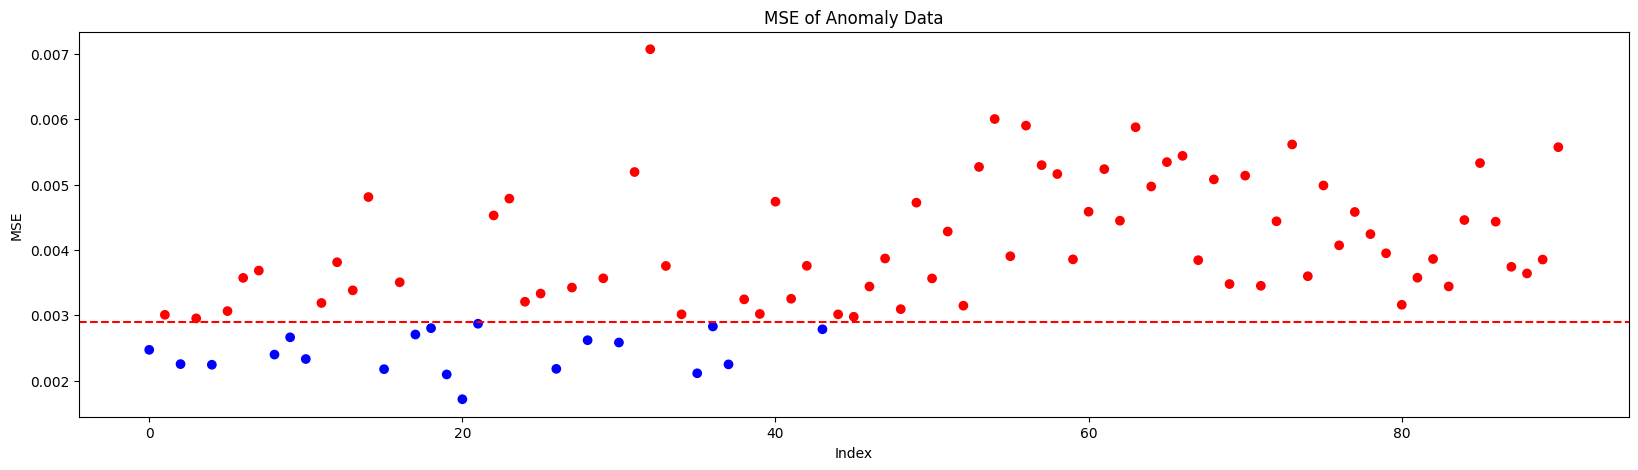

In [16]:
# plot anomalies scatter plot
plt.figure(figsize=(20, 5))
# use red color if mse > mse_threshold
plt.scatter(range(0, len(test_reconstruction_errors)), test_reconstruction_errors, 
            color=['red' if loss > threshold else 'blue' for loss in test_reconstruction_errors])
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('MSE of Anomaly Data')
plt.xlabel('Index')
plt.xticks(range(0, len(test_reconstruction_errors), 20))
plt.ylabel('MSE')
plt.savefig('images/mse_anomaly.png')
print(f'Failed reconstruction count is {len(anomalies_index)}, total test data is {len(test_data)}')
print(f'Failed reconstruction rate is {len(anomalies_index) / len(test_data) * 100}%')
